started
(88, 128, 3)


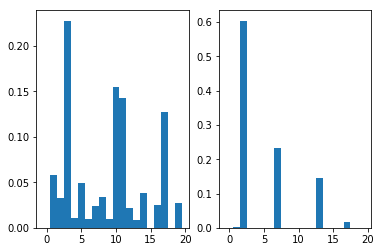

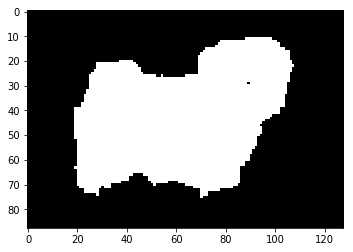

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

np.random.seed(42)

def kmeans(pixels, NClusters):
    km = KMeans(NClusters)
    fitted = km.fit(pixels)
    return (fitted.cluster_centers_, fitted.labels_, fitted.inertia_)

def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]

        return n

    if(size == 8):
        n = []
        for x in range (i-1, i+1+1):
            for y in range(j-1, j+1+1):
                if (x >= 0 and x < M):
                    if (y >= 0 and y < N):
                        if (y != j or x != i):
                            n.append((x,y))
        return n

def imagesRead(image, mask):
    image = imread(image)
    masks = imread(mask)
    return (image, masks)
    
def maskPixels(image, masks):
    forePixels = []
    backPixels = []
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if(masks[i][j][0] == 255):
                if(masks[i][j][1] == 0):
                    if(masks[i][j][2] == 0):
                        forePixels.append(image[i][j])
                        masks[i][j] = [255,255,255,255]
            if(masks[i][j][0] == 0):
                if(masks[i][j][1] == 255):
                    if(masks[i][j][2] == 0):
                        backPixels.append(image[i][j])
                        masks[i][j] = [0,0,0,255]
    return (forePixels, backPixels)

def doSinglePlot(image):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.imshow(image)
    plt.show()
    
def plotClusters(centroids, means, rgb):
    clust0 = np.where(means[1] == 0)
    clust1 = np.where(means[1] == 1)
    clust2 = np.where(means[1] == 2)
    clust3 = np.where(means[1] == 3)
    clust4 = np.where(means[1] == 4)
    clust5 = np.where(means[1] == 5)
    clusters = (clust0, clust1, clust2, clust3, clust4, clust5)

    cluster0 = rgb[clust0]
    cluster1 = rgb[clust1]
    cluster2 = rgb[clust2]
    cluster3 = rgb[clust3]
    cluster4 = rgb[clust4]
    cluster5 = rgb[clust5]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(cluster0[:,0].tolist(), cluster0[:,1].tolist(), c = 'orange')
    ax.scatter(cluster1[:,0].tolist(), cluster1[:,1].tolist(), c = 'purple')
    ax.scatter(cluster2[:,0].tolist(), cluster2[:,1].tolist(), c = 'green')
    ax.scatter(cluster3[:,0].tolist(), cluster3[:,1].tolist(), c = 'pink')
    ax.scatter(cluster4[:,0].tolist(), cluster4[:,1].tolist(), c = 'yellow')
    ax.scatter(cluster5[:,0].tolist(), cluster5[:,1].tolist(), c = 'red')

    plt.show()
    
def L(x, y, centroids, foreHist, backHist):
    y = np.reshape(y, (1,3))
    #get distances from clusters,
    distance = cdist(y, centroids, metric='euclidean')
    #find out which cluster y belongs to
    cluster = np.argmin(distance)
    #return 1 if p(y = x) > p(y != x)
    if(x == -1): #if x is background
        if(foreHist[cluster] <= backHist[cluster]):
            return 1
        else:
            return 0
    elif(x == 1): #if x is foreground
        if(foreHist[cluster] >= backHist[cluster]):
            return 1
        else:
            return 0
    
def E(w, x, i, j, size = 4):
    sum = 0
    for neighbour in neighbours(i, j, x.shape[0], x.shape[1], size = size):
        sum += w[i][j] * x[i][j] * x[neighbour[0]][neighbour[1]]
    return sum
    
def segment(image, x, foreHist, backHist, centroids, iterations = 10):
    xt = np.copy(x)
    w = np.ones(x.shape)
    for T in range (0, iterations):
        for i in range (xt.shape[0]):
            for j in range (xt.shape[1]):
                xt[i][j] = 1
                nominator = np.exp(L(xt[i][j], image[i][j], centroids, foreHist, backHist)) * np.exp(E(w, xt, i, j))

                denom_left = np.exp(L(xt[i][j], image[i][j], centroids, foreHist, backHist)) * np.exp(E(w, xt, i, j))
                xt[i][j] = -1
                denom_right = np.exp(L(xt[i][j], image[i][j], centroids, foreHist, backHist)) * np.exp(E(w, xt, i, j))
                denominator = denom_left + denom_right
                p_i = nominator / denominator
                t = np.random.uniform(0,1)
                if p_i > t:
                    xt[i][j] = 1
                else:
                    xt[i][j] = -1   
    return xt


print("started")
image, maskPic = imagesRead("grass_pug_new.png", "grass_pug_new_mask.png")
print(image.shape)
#Read in RGB image
bins = 20

#K-means, gets clusters
red = []
blue = []
green = []
for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
        red.append(image[i][j][0])
        blue.append(image[i][j][1])
        green.append(image[i][j][2])

# plt.scatter(red, green)
# plt.scatter(red, blue)
# plt.scatter(blue, green)
# plt.show()

rgb = [red,green,blue]
# print(len(rgb), len(rgb[0]),len(rgb[1]),len(rgb[2]))
rgb = np.reshape(rgb, (len(rgb[0]), len(rgb)))

# plt.hist(image[:,:,0].flatten())
# plt.hist(image[:,:,1].flatten())
# plt.hist(image[:,:,2].flatten())
# plt.show()

means = kmeans(rgb, bins)
centroids = means[0]

# plotClusters(centroids, means, rgb)

#get foreground/background pixels
forePix, backPix = maskPixels(image, maskPic)
# doSinglePlot(maskPic)

#do nearest neighbour classifying for foreground/ background pixels
foreSeperation = cdist(forePix, centroids, metric='euclidean')
# print(foreSeperation)
backSeperation = cdist(backPix, centroids, metric='euclidean')

foreIndexes = np.argmin(foreSeperation, axis = 1)
# print(foreIndexes)
backIndexes = np.argmin(backSeperation, axis = 1)

# foreIndexes = foreIndexes.reshape(-1,1)
#make a histogram distribution
foreHist = np.histogram(foreIndexes, bins = bins, density = True, range = (-0.5, bins-0.5))[0]
backHist = np.histogram(backIndexes, bins = bins, density = True, range = (-0.5, bins-0.5))[0]


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(foreIndexes, bins = bins, density = True, range = (-0.5, bins-0.5))
ax2.hist(backIndexes, bins = bins, density = True, range = (-0.5, bins-0.5))
plt.show()

# print(foreHist-
# #normalize histograms
# # foreHist = foreHist/sum(foreHist) #probabilities of that cluster being in that thing
# # backHist = backHist/sum(backHist)


# #initialise random field
fig = plt.figure()
x = np.random.choice((-1, 1), (image.shape[0], image.shape[1]))
# print(centroids)
segmentImage = segment(image, x, foreHist, backHist, centroids, iterations = 80)

ax1 = fig.add_subplot(111)
ax1.imshow(segmentImage, cmap = 'gray')
plt.show()

# print("we did it")
# #Get result
# #Simples ;)